<a href="https://colab.research.google.com/github/omerfcinoglu/Turkish_Sentiment_Analysis/blob/main/BERT%C3%BCrk_BiLSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install "transformers[tf]" datasets

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/TSA-Dataset/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/TSA-Dataset/test.csv")

label_map = {"Positive": 0, "Notr": 1, "Negative": 2}

df_train = df_train[df_train["label"].isin(label_map.keys())].copy()
df_test = df_test[df_test["label"].isin(label_map.keys())].copy()

df_train["label_id"] = df_train["label"].map(label_map)
df_test["label_id"] = df_test["label"].map(label_map)

train_df, val_df = train_test_split(
    df_train,
    test_size=0.1,
    random_state=42,
    stratify=df_train["label_id"]
)

test_df = df_test.copy()

In [4]:
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_len = 128
batch_size = 32

def encode_texts(texts):
    encodings = tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="np"
    )
    return encodings["input_ids"], encodings["attention_mask"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [5]:
X_train_ids, X_train_mask = encode_texts(train_df["text"])
X_val_ids, X_val_mask = encode_texts(val_df["text"])
X_test_ids, X_test_mask = encode_texts(test_df["text"])

y_train = train_df["label_id"].to_numpy()
y_val = val_df["label_id"].to_numpy()
y_test = test_df["label_id"].to_numpy()

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train_ids, X_train_mask), y_train)).shuffle(len(y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val_ids, X_val_mask), y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_test_ids, X_test_mask), y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
bert = TFAutoModel.from_pretrained(model_name, from_pt=True)

input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

bert_outputs = bert(input_ids, attention_mask=attention_mask)
sequence_output = bert_outputs.last_hidden_state

x = tf.keras.layers.Dropout(0.3)(sequence_output)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)

c1 = tf.keras.layers.Conv1D(128, 3, activation="relu")(x)
c1 = tf.keras.layers.GlobalMaxPooling1D()(c1)

c2 = tf.keras.layers.Conv1D(128, 4, activation="relu")(x)
c2 = tf.keras.layers.GlobalMaxPooling1D()(c2)

c3 = tf.keras.layers.Conv1D(128, 5, activation="relu")(x)
c3 = tf.keras.layers.GlobalMaxPooling1D()(c3)

merged = tf.concat([c1, c2, c3], axis=-1)

h = tf.keras.layers.Dense(128, activation="relu")(merged)
h = tf.keras.layers.Dropout(0.3)(h)

outputs = tf.keras.layers.Dense(3, activation="softmax")(h)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForS

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1106173   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stop]
)

test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

Epoch 1/3


12395/12395 [==============================] - 1516s 117ms/step - loss: 0.0987 - accuracy: 0.9654 - val_loss: 0.0794 - val_accuracy: 0.9730
Epoch 2/3
12395/12395 [==============================] - 1356s 109ms/step - loss: 0.0652 - accuracy: 0.9783 - val_loss: 0.0819 - val_accuracy: 0.9711
Epoch 3/3
1531/1531 [==============================] - 66s 43ms/step - loss: 0.0790 - accuracy: 0.9720
Test accuracy: 0.9720208048820496



--- Making Predictions on the Model Test Set... ---
1531/1531 [==============================] - 69s 43ms/step

DETAILED MODEL PERFORMANCE (CLASSIFICATION REPORT)
              precision    recall  f1-score   support

Positive (0)       0.97      0.98      0.97     26217
 Neutral (1)       1.00      1.00      1.00     17092
Negative (2)       0.92      0.84      0.88      5656

    accuracy                           0.97     48965
   macro avg       0.96      0.94      0.95     48965
weighted avg       0.97      0.97      0.97     48965



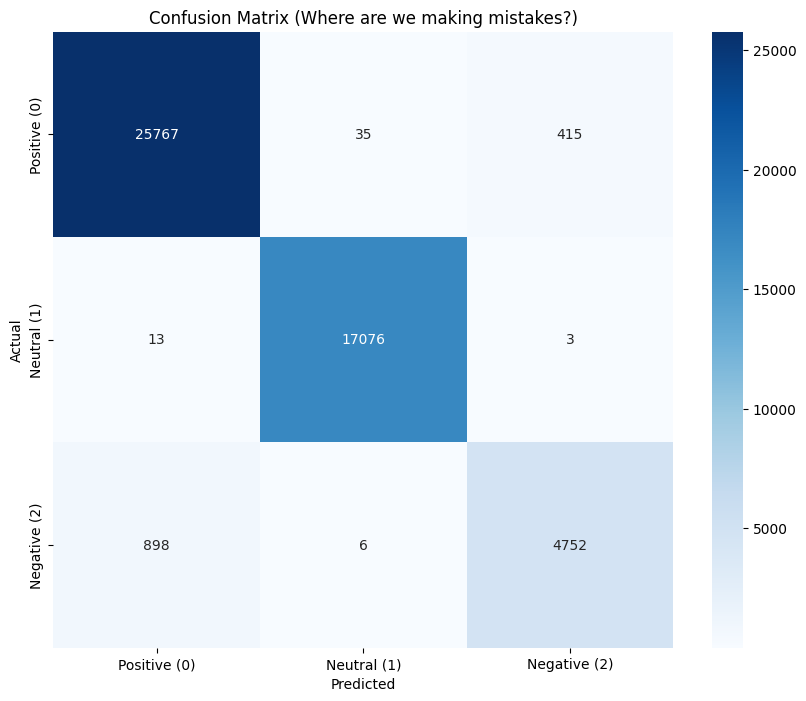

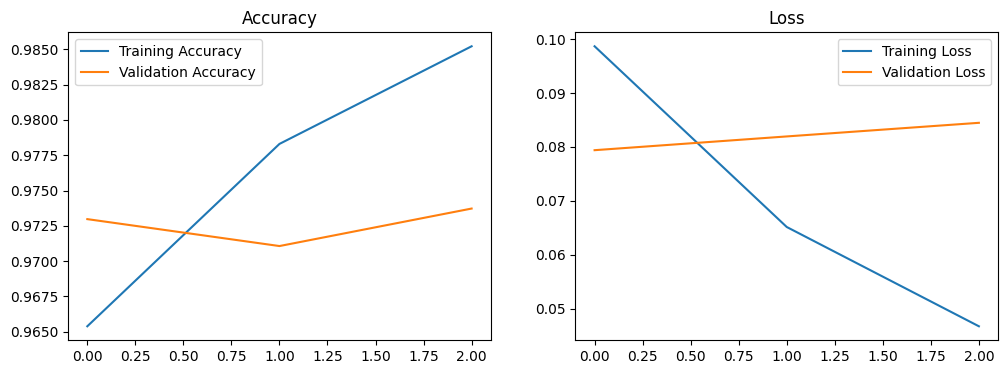

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Making Predictions on the Model Test Set... ---")
# Get the model's probability predictions (e.g., [0.1, 0.2, 0.7])
y_pred_probs = model.predict([X_test_ids, X_test_mask])
# Select the class with the highest probability (0, 1, or 2)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 1. CLASSIFICATION REPORT
# Shows Precision, Recall, and F1 scores separately for each class.
print("\n" + "="*50)
print("DETAILED MODEL PERFORMANCE (CLASSIFICATION REPORT)")
print("="*50)
target_names = ['Positive (0)', 'Neutral (1)', 'Negative (2)']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# 2. CONFUSION MATRIX
# Heatmap showing which classes the model confused with others.
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Where are we making mistakes?)')
plt.show()

# 3. TRAINING PLOTS
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()